In [2]:
import pandas as pd

In [ ]:
!pip install  nba_api

In [64]:
from nba_api.stats.static import teams

nba_teams = teams.get_teams()

# We select the LA Clippers and we extract the team id
clippers = [team for team in nba_teams if team['abbreviation'] == 'LAC'][0]
clippers_id = clippers['id'] 
print(f"clippers_id: {clippers_id}")

clippers_id: 1610612746


In [65]:
# We extract all 2024-25 season Clippers' games
from nba_api.stats.endpoints import leaguegamefinder

gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=clippers_id,
                                            season_nullable='2024-25',
                                            season_type_nullable='Regular Season')

games = gamefinder.get_normalized_dict()['LeagueGameFinderResults']

In [66]:
# Function that returns the opponent abbreviation team from the matchup. Ex: LAC vs. OKC => OKC
def getOpponentABB(matchup):
    return matchup[-3:]

# Function that returns the score of the opponent team from our team PTS and the PLUS_MINUS. Ex: PTS=101, PLUS_MINUS=-2 => 103
def getOpponentScore(PTS,PLUS_MINUS):
    return int(PTS + PLUS_MINUS)

# Function that return if the game was played at home (H) or away (A) using matchup info. Ex: LAC vs. OKC => H, LAC @ ATL => A. 
def getHAValue(matchup):
    return 'A' if '@' in matchup else 'H'

def loadGamesDF(games):
    columns = ['TEAM_ID','TEAM_ABBREVIATION','TEAM_NAME','GAME_ID','GAME_DATE','MATCHUP','WL','OPP_TEAM_ABBREVIATION','LAC_PTS','OPP_PTS','PLUS_MINUS','HA']
    gamesDF = pd.DataFrame(games)

    gamesDF = gamesDF.rename(columns={f'PTS':'LAC_PTS'})
    gamesDF['OPP_TEAM_ABBREVIATION'] = gamesDF['MATCHUP'].apply(getOpponentABB)
    gamesDF['OPP_PTS'] = gamesDF.apply(lambda x: getOpponentScore(x['LAC_PTS'],x['PLUS_MINUS']*-1),axis=1)
    gamesDF['HA'] = gamesDF['MATCHUP'].apply(getHAValue)

    return gamesDF[columns]

gamesDF = loadGamesDF(games)
gamesDF.head()

,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,OPP_TEAM_ABBREVIATION,LAC_PTS,OPP_PTS,PLUS_MINUS,HA
0,1610612746,LAC,LA Clippers,0022401036,2025-03-23,LAC vs. OKC,L,OKC,101,103,-2.0,H
1,1610612746,LAC,LA Clippers,0022401023,2025-03-21,LAC vs. MEM,W,MEM,128,108,20.0,H
2,1610612746,LAC,LA Clippers,0022400997,2025-03-18,LAC vs. CLE,W,CLE,132,119,13.0,H
3,1610612746,LAC,LA Clippers,0022400538,2025-03-16,LAC vs. CHA,W,CHA,123,88,35.0,H
4,1610612746,LAC,LA Clippers,0022400960,2025-03-14,LAC @ ATL,W,ATL,121,98,23.0,A


In [107]:
gamesDF.to_csv('ClippersSchedule2425.csv')

In [67]:
plays = pd.DataFrame()

In [68]:
from nba_api.stats.endpoints import playbyplay

# We extract the GAME ID for each Clippers game.
gamesID = [game['GAME_ID'] for game in games]
"""
for id in range(60,75):
    playsGame = playbyplay.PlayByPlay(game_id=gamesID[id],timeout=100).get_data_frames()[0][['GAME_ID','EVENTMSGTYPE','PERIOD','PCTIMESTRING','HOMEDESCRIPTION','NEUTRALDESCRIPTION','VISITORDESCRIPTION','SCORE','SCOREMARGIN']]
    playsGame = playsGame[playsGame['SCORE'].notnull()] # We get only events that affect the score.
    plays = pd.concat([plays,playsGame])

plays
"""

"\nfor id in range(60,75):\n    playsGame = playbyplay.PlayByPlay(game_id=gamesID[id],timeout=100).get_data_frames()[0][['GAME_ID','EVENTMSGTYPE','PERIOD','PCTIMESTRING','HOMEDESCRIPTION','NEUTRALDESCRIPTION','VISITORDESCRIPTION','SCORE','SCOREMARGIN']]\n    playsGame = playsGame[playsGame['SCORE'].notnull()] # We get only events that affect the score.\n    plays = pd.concat([plays,playsGame])\n\nplays\n"

In [69]:
#plays.to_csv('ClippersGamesPlays.csv')

In [73]:

plays = pd.read_csv('ClippersGamesPlays.csv')

In [74]:
from datetime import datetime, date, time

# The PCTIMESTRING column give us the time left in the period, while we need to calculate the Total Played Time.
def calculateTime(PERIOD,PCTIMESTRING):

    # This formula allows us to obtain the played time from the time left and the period. PCTIMESTRING = 10:37, PERIOD = 1 => PLAYED_TIME= 0:01:23

    minutes,seconds = PCTIMESTRING.split(':')
    try:
        timeLeft = datetime.combine(datetime.now().date(),time(0,int(minutes),int(seconds)))
        
        # Case for overtime.
        if PERIOD > 4:
            totalMinutes = 48 + 5 * (PERIOD - 4)
        else:
            totalMinutes = 12 * PERIOD  

        periodTime = datetime.combine(datetime.now().date(),time(0,totalMinutes,0))

        playedTime = periodTime - timeLeft
        playedTime = str(playedTime).split(", ")[-1]

        
        return playedTime
    except:
        print(PERIOD,PCTIMESTRING,minutes,seconds)

def getTime(df):
    return df.apply(lambda x: calculateTime(x['PERIOD'],x['PCTIMESTRING']),axis=1)

plays['PLAYED_TIME'] = getTime(plays)

In [105]:
clippersPlays = pd.DataFrame()

def extractTeamScore(HOME,SCORE):
    visitorScore, homeScore = SCORE.split('-')
    if pd.isna(HOME):
        return visitorScore
    else:
        return homeScore
    
def getOurTeamPlays(gamesDF,plays, clippersPlays):
    for game in gamesDF.iterrows():
        gameID, HA = game[1][['GAME_ID','HA']]
        if HA == 'H':
            clippersPlays = pd.concat([clippersPlays, plays[(plays['HOMEDESCRIPTION'].notnull()) & (plays['GAME_ID']==int(gameID))]])
        else:
            clippersPlays = pd.concat([clippersPlays, plays[(plays['VISITORDESCRIPTION'].notnull()) & (plays['GAME_ID']==int(gameID))]])

    clippersPlays['LAC_SCORE'] = clippersPlays.apply(lambda x: extractTeamScore(x['HOMEDESCRIPTION'],x['SCORE']),axis=1)
    return clippersPlays

clippersPlays = getOurTeamPlays(gamesDF,plays, clippersPlays)
clippersPlays.head()

,Unnamed: 0,GAME_ID,EVENTMSGTYPE,PERIOD,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,SCORE,SCOREMARGIN,PLAYED_TIME,LAC_SCORE
1,21,22401036,1,1,9:58,Zubac Putback Dunk (2 PTS),NaN,NaN,2 - 2,TIE,0:02:02,2
3,23,22401036,1,1,9:30,Zubac 3' Driving Reverse Layup (4 PTS),NaN,NaN,4 - 4,TIE,0:02:30,4
5,33,22401036,1,1,7:55,Zubac 7' Driving Hook Shot (6 PTS) (Harden 1 AST),NaN,NaN,7 - 6,-1,0:04:05,6
7,35,22401036,1,1,7:16,Dunn 8' Driving Floating Jump Shot (2 PTS) (Ha...,NaN,NaN,9 - 8,-1,0:04:44,8
9,40,22401036,1,1,6:26,Dunn 10' Driving Floating Jump Shot (4 PTS) (L...,NaN,NaN,12 - 10,-2,0:05:34,10


In [106]:
clippersPlays.to_csv('OnlyClippersPlays.csv')

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

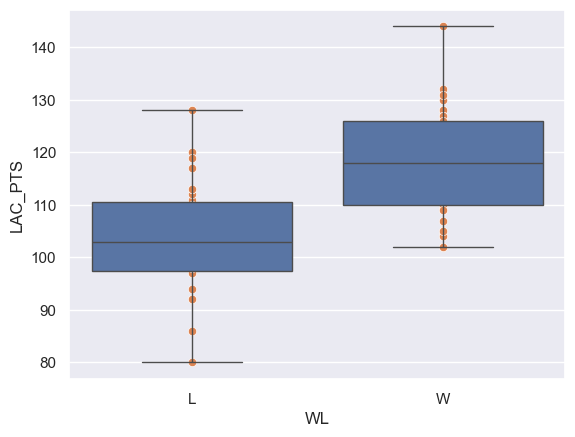

In [77]:
sns.boxplot(data=gamesDF,x="WL",y="LAC_PTS")
sns.scatterplot(data=gamesDF, x="WL",y="LAC_PTS")
plt.show()